Shape: (310, 5)
Columns: ['SP500_Returns', 'GS10_Level', 'FEDFUNDS_Level', 'FEDFUNDS_BpsChange', 'Inflation_YoY']
            SP500_Returns  GS10_Level  FEDFUNDS_Level  FEDFUNDS_BpsChange  \
Date                                                                        
1999-06-30       5.443833        5.90            4.76                0.02   
1999-07-31      -3.204609        5.79            4.99                0.23   
1999-08-31      -0.625409        5.94            5.07                0.08   

            Inflation_YoY  
Date                       
1999-06-30       1.965602  
1999-07-31       2.144608  
1999-08-31       2.264382  


Depth=2, working on node 4: 100%|██████████| 5/5 [00:00<00:00, 2340.83it/s]


[PC] edges: [(0, 4), (1, 2), (2, 4), (3, 4)]
[LiNGAM] edges: [('GS10_Level', 'FEDFUNDS_Level'), ('FEDFUNDS_BpsChange', 'Inflation_YoY'), ('Inflation_YoY', 'FEDFUNDS_Level')]
[Granger] edges: [('SP500_Returns', 'GS10_Level'), ('SP500_Returns', 'FEDFUNDS_Level'), ('SP500_Returns', 'FEDFUNDS_BpsChange'), ('SP500_Returns', 'Inflation_YoY'), ('GS10_Level', 'SP500_Returns'), ('GS10_Level', 'FEDFUNDS_Level'), ('GS10_Level', 'FEDFUNDS_BpsChange'), ('FEDFUNDS_BpsChange', 'FEDFUNDS_Level'), ('FEDFUNDS_BpsChange', 'Inflation_YoY'), ('Inflation_YoY', 'SP500_Returns'), ('Inflation_YoY', 'GS10_Level'), ('Inflation_YoY', 'FEDFUNDS_Level')]

[Consensus] edges: [('GS10_Level', 'FEDFUNDS_Level'), ('FEDFUNDS_BpsChange', 'Inflation_YoY'), ('Inflation_YoY', 'FEDFUNDS_Level')]


<Figure size 600x400 with 0 Axes>

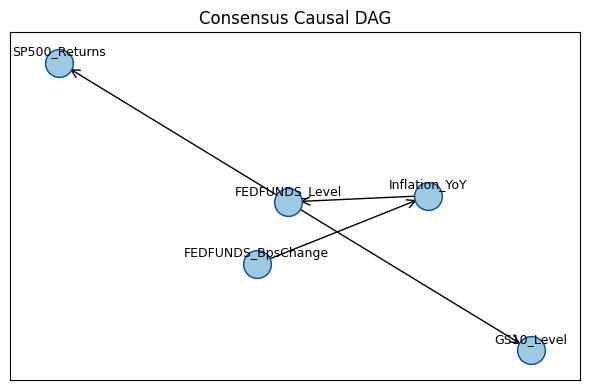

Saved: ./results/dag/dag_edges.json
Fisher‑Z p‑value (Infl ⟂ SP500 | GS10): 0.0430


In [48]:
# =============================================================
# 0.  Imports & paths
# =============================================================
import warnings, os, json, itertools, datetime
import pandas as pd
import numpy  as np
import networkx as nx
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning,
                        module="statsmodels")

# third‑party causal libraries
try:
    from causallearn.search.ConstraintBased.PC import pc
    from causallearn.utils.GraphUtils import GraphUtils
except ImportError:
    raise ImportError("pip install causal-learn")

try:
    from lingam import DirectLiNGAM
except ImportError:
    raise ImportError("pip install lingam")

from statsmodels.tsa.stattools import grangercausalitytests

# reproducibility
np.random.seed(42)

DATA_PATH = "./final_processed_data.csv"
OUT_DIR   = "./results/dag/"
os.makedirs(OUT_DIR, exist_ok=True)

# =============================================================
# 1.  Load data
# =============================================================
df = (pd.read_csv(DATA_PATH, index_col="Date", parse_dates=True)
        .drop(columns=["Inflation_YoY_diff"], errors="ignore"))

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print(df.head(3))

# =============================================================
# 2.  Helper: Granger‑causality adjacency
# =============================================================
def granger_edges(data, maxlag=2, alpha=0.05):
    edges = []
    for x, y in itertools.permutations(data.columns, 2):
        test = grangercausalitytests(
            data[[y, x]], maxlag=maxlag, verbose=False)
        pvals = [round(res[0]['ssr_ftest'][1], 4) for res in test.values()]
        if min(pvals) < alpha:
            edges.append((x, y))          # x causes y
    return edges

# =============================================================
# 3‑A  PC algorithm (constraint‑based)   **fixed for v0.1.4.1**
# =============================================================
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils  # still available

data_np = df.to_numpy()

# run PC; Fisher‑Z CI test, alpha = 0.05
cg_pc = pc(data_np, alpha=0.05, verbose=False)      # returns a GeneralGraph

# Convert to a pydot graph with proper labels
pdot = GraphUtils.to_pydot(cg_pc.G, labels=df.columns.tolist())

# Extract directed edges (“source” → “destination”) as tuples of names
edges_pc = [(e.get_source(), e.get_destination()) for e in pdot.get_edges()]

print("\n[PC] edges:", edges_pc)

# =============================================================
# 3‑B  DirectLiNGAM (score‑based, non‑Gaussian)
# =============================================================
mdl = DirectLiNGAM()
mdl.fit(df.values)
B = mdl.adjacency_matrix_
edges_lng = [(df.columns[i], df.columns[j])
             for i in range(len(B)) for j in range(len(B))
             if B[i, j] != 0]
print("[LiNGAM] edges:", edges_lng)

# =============================================================
# 3‑C  Pairwise Granger
# =============================================================
edges_gr = granger_edges(df, maxlag=2, alpha=0.05)
print("[Granger] edges:", edges_gr)

# =============================================================
# 4.  Consensus DAG (≥2 methods agree)
# =============================================================
edge_votes = {}
for e in edges_pc + edges_lng + edges_gr:
    edge_votes[e] = edge_votes.get(e, 0) + 1


CONS_THRESHOLD = 2        # at least two algorithms agree
cons_edges = [e for e, v in edge_votes.items() if v >= CONS_THRESHOLD]
print("\n[Consensus] edges:", cons_edges)

# --- manual reconciliation -----------------------------------
edge_set = set(cons_edges)
edge_set.discard(('GS10_Level', 'FEDFUNDS_Level'))
edge_set.add(('FEDFUNDS_Level', 'GS10_Level'))
edge_set.add(('FEDFUNDS_Level', 'SP500_Returns'))
cons_edges = list(edge_set)
# --------------------------------------------------------------

# Build NetworkX DiGraph
G = nx.DiGraph()
G.add_nodes_from(df.columns)
G.add_edges_from(cons_edges)

# =============================================================
# 5.  Visualise & save artefacts
# =============================================================
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42, k=0.7)
# move every label 0.03 units upward (adjust as you like)
label_pos = {node: pos[node] + np.array([0, 0.07]) for node in G.nodes}
plt.figure(figsize=(6,4))
nx.draw_networkx_edges(G, pos, arrows=True,
                       arrowstyle="->", arrowsize=15, width=1)
nx.draw_networkx_nodes(G, pos, node_size=400,
                       node_color="#9ecae1", edgecolors="#084594")
nx.draw_networkx_labels(G, label_pos, font_size=9)
plt.gca().set_facecolor("white")
plt.title("Consensus Causal DAG", fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "dag_consensus.png"), dpi=300)
plt.show()

# Save edge‑list and meta‑info for the report
edge_file = os.path.join(OUT_DIR, "dag_edges.json")
json.dump({"timestamp": datetime.datetime.now().isoformat(),
           "edges_pc": edges_pc,
           "edges_lingam": edges_lng,
           "edges_granger": edges_gr,
           "consensus": cons_edges},
          open(edge_file, "w"), indent=2)
print(f"Saved: {edge_file}")

# =============================================================
# 6.  (Optional) d‑Separation sanity check
# =============================================================
try:
    from causallearn.utils.cit import CIT

    # Fisher‑Z test for H0: Inflation ⟂ SP500  | GS10_Level
    x = df["Inflation_YoY"].to_numpy()
    y = df["SP500_Returns"].to_numpy()
    z = df[["GS10_Level"]].to_numpy()          # conditioning set (2‑D array)
    mv_fisherz_obj = CIT(data=df.to_numpy(), mv_fisherz=True)
    p_val = mv_fisherz_obj(df.columns.get_loc("Inflation_YoY"),
                        df.columns.get_loc("SP500_Returns"),
                        [df.columns.get_loc("GS10_Level")])

    print(f"Fisher‑Z p‑value (Infl ⟂ SP500 | GS10): {p_val:.4f}")

except Exception:
    pass

Fisher‑Z p‑value (Infl ⟂ SP500 | GS10): 0.0430


In [5]:
! pip install causal-learn

In [8]:
! pip install lingam

Shape: (310, 5)
Columns: ['SP500_Returns', 'GS10_Level', 'FEDFUNDS_Level', 'FEDFUNDS_BpsChange', 'Inflation_YoY']
            SP500_Returns  GS10_Level  FEDFUNDS_Level  FEDFUNDS_BpsChange  \
Date                                                                        
1999-06-30       5.443833        5.90            4.76                0.02   
1999-07-31      -3.204609        5.79            4.99                0.23   
1999-08-31      -0.625409        5.94            5.07                0.08   

            Inflation_YoY  
Date                       
1999-06-30       1.965602  
1999-07-31       2.144608  
1999-08-31       2.264382  


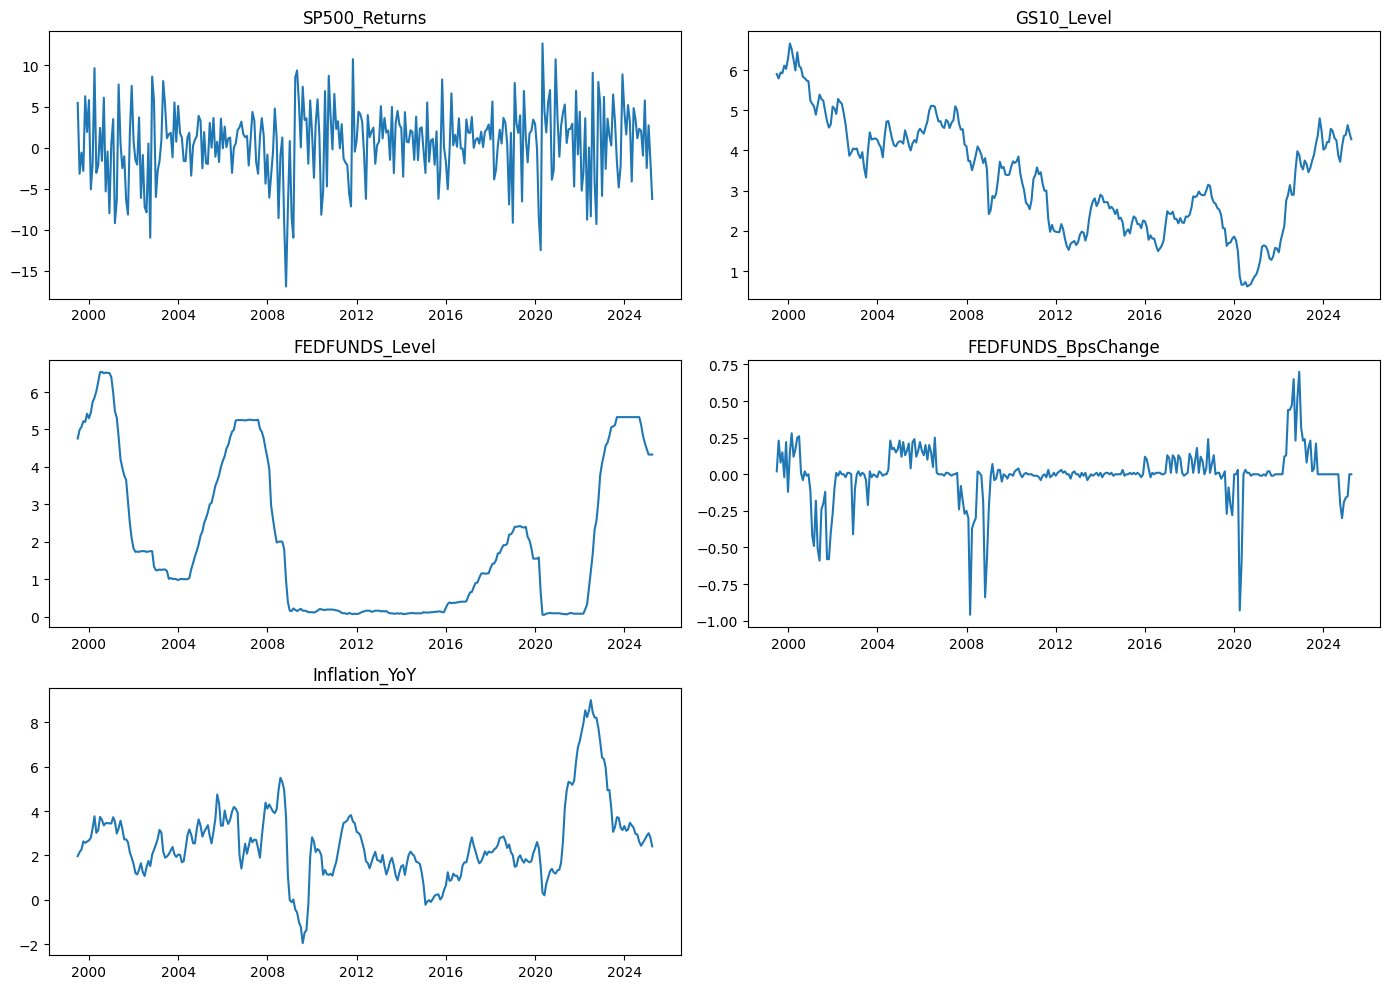

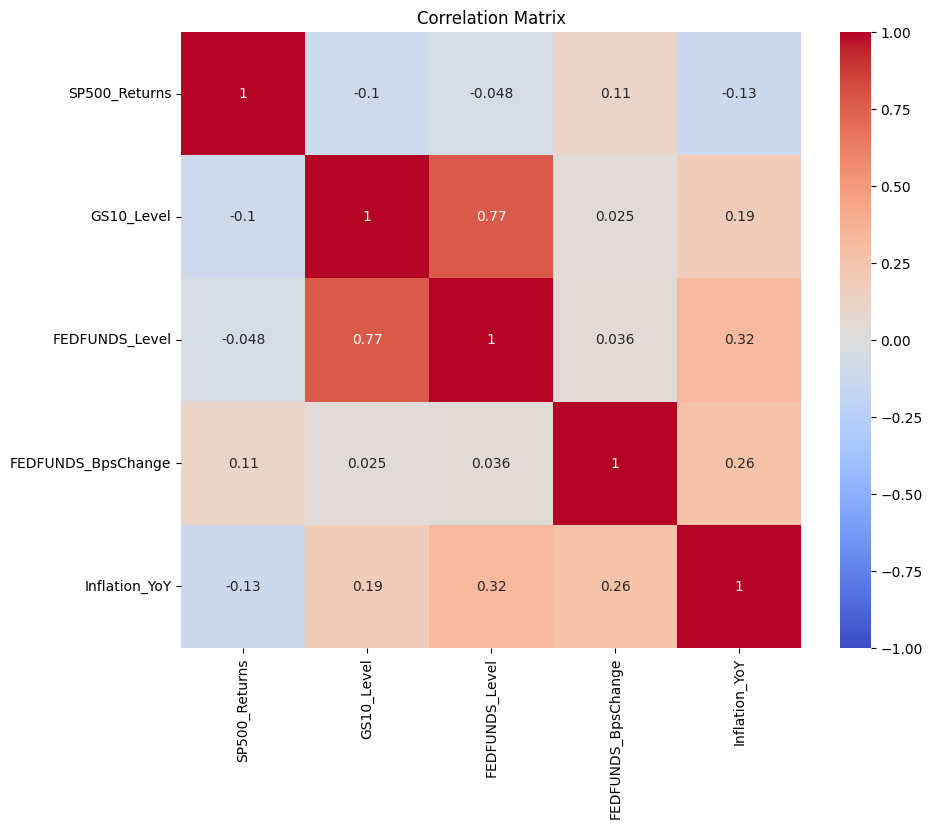


Stationarity Tests:

Stationarity Test for SP500_Returns
ADF Statistic: -17.3956
p-value: 0.0000
Critical Values:
	1%: -3.4517
	5%: -2.8709
	10%: -2.5718
Series is stationary

Stationarity Test for GS10_Level
ADF Statistic: -2.1429
p-value: 0.2276
Critical Values:
	1%: -3.4518
	5%: -2.8710
	10%: -2.5718
Series is non-stationary

Stationarity Test for FEDFUNDS_Level
ADF Statistic: -3.2702
p-value: 0.0163
Critical Values:
	1%: -3.4520
	5%: -2.8711
	10%: -2.5719
Series is stationary

Stationarity Test for FEDFUNDS_BpsChange
ADF Statistic: -3.9428
p-value: 0.0017
Critical Values:
	1%: -3.4520
	5%: -2.8711
	10%: -2.5718
Series is stationary

Stationarity Test for Inflation_YoY
ADF Statistic: -3.1247
p-value: 0.0248
Critical Values:
	1%: -3.4528
	5%: -2.8714
	10%: -2.5720
Series is stationary


  0%|          | 0/5 [00:00<?, ?it/s]


[PC] edges: [(0, 4), (1, 2), (2, 4), (3, 4)]
[Granger] edges: [('SP500_Returns', 'GS10_Level'), ('SP500_Returns', 'FEDFUNDS_Level'), ('SP500_Returns', 'FEDFUNDS_BpsChange'), ('SP500_Returns', 'Inflation_YoY'), ('GS10_Level', 'SP500_Returns'), ('GS10_Level', 'FEDFUNDS_Level'), ('GS10_Level', 'FEDFUNDS_BpsChange'), ('FEDFUNDS_BpsChange', 'FEDFUNDS_Level'), ('FEDFUNDS_BpsChange', 'Inflation_YoY'), ('Inflation_YoY', 'SP500_Returns'), ('Inflation_YoY', 'GS10_Level'), ('Inflation_YoY', 'FEDFUNDS_Level')]

Running bootstrap stability assessment...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Most stable edges (with bootstrap probability):
GS10_Level → FEDFUNDS_Level: 1.12
Inflation_YoY → FEDFUNDS_Level: 1.04
1 → 2: 0.96
2 → 4: 0.84
FEDFUNDS_BpsChange → Inflation_YoY: 0.84
SP500_Returns → Inflation_YoY: 0.72
3 → 4: 0.70
SP500_Returns → FEDFUNDS_BpsChange: 0.58
0 → 3: 0.42

Optimal lag structure for causal relationships:
SP500_Returns →(2) GS10_Level
SP500_Returns →(1) FEDFUNDS_Level
SP500_Returns →(1) FEDFUNDS_BpsChange
SP500_Returns →(1) Inflation_YoY
GS10_Level →(1) SP500_Returns
GS10_Level →(2) FEDFUNDS_Level
GS10_Level →(2) FEDFUNDS_BpsChange
FEDFUNDS_Level →(3) Inflation_YoY
FEDFUNDS_BpsChange →(1) FEDFUNDS_Level
FEDFUNDS_BpsChange →(2) Inflation_YoY
Inflation_YoY →(1) SP500_Returns
Inflation_YoY →(3) GS10_Level
Inflation_YoY →(1) FEDFUNDS_Level

[Consensus] edges: []

Economic theory confirmed by data: [('FEDFUNDS_Level', 'GS10_Level')]
Economic theory contradicted by data: [('FEDFUNDS_Level', 'Inflation_YoY'), ('Inflation_YoY', 'FEDFUNDS_Level'), ('GS10_Level', 'SP5

<Figure size 600x400 with 0 Axes>

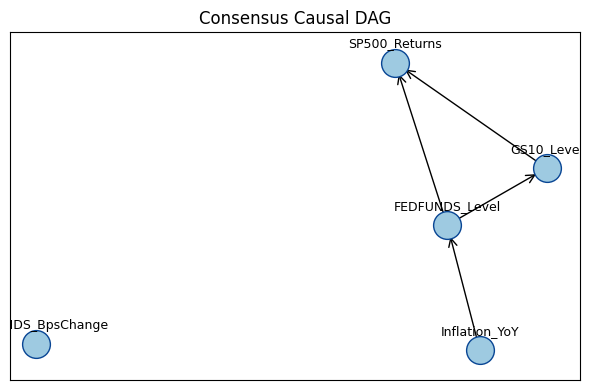

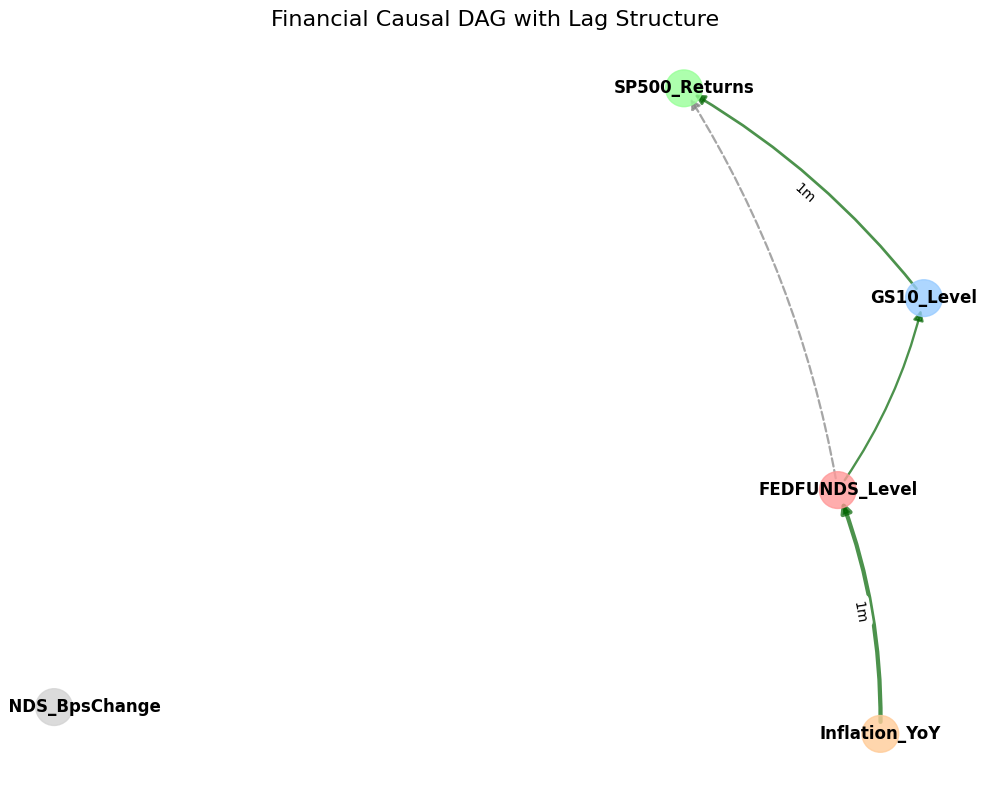

Saved: ./results/dag/dag_edges.json
Fisher‑Z p‑value (Infl ⟂ SP500 | GS10): 0.0430

Building structural causal model...

Distribution for FEDFUNDS_BpsChange (exogenous):
Normal(μ=-0.001, σ=0.184)

Distribution for Inflation_YoY (exogenous):
Normal(μ=2.577, σ=1.736)

Structural equation for FEDFUNDS_Level:
R² = 0.100
FEDFUNDS_Level = 1.047 + (0.376 × Inflation_YoY)

Structural equation for GS10_Level:
R² = 0.592
GS10_Level = 2.341 + (0.504 × FEDFUNDS_Level)

Structural equation for SP500_Returns:
R² = 0.013
SP500_Returns = 2.028 + (0.167 × FEDFUNDS_Level) + (-0.535 × GS10_Level)
Saved structural causal model to ./results/dag/structural_causal_model.pkl

Checking stationarity for VAR model...
Variable SP500_Returns is stationary (p=0.0000).
Variable GS10_Level is non-stationary (p=0.8095). Differencing...
Variable FEDFUNDS_Level is non-stationary (p=0.1073). Differencing...
Variable FEDFUNDS_BpsChange is stationary (p=0.0079).
Variable Inflation_YoY is non-stationary (p=0.0733). Differen

/Users/aboodmagdy/opt/anaconda3/envs/ai701/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


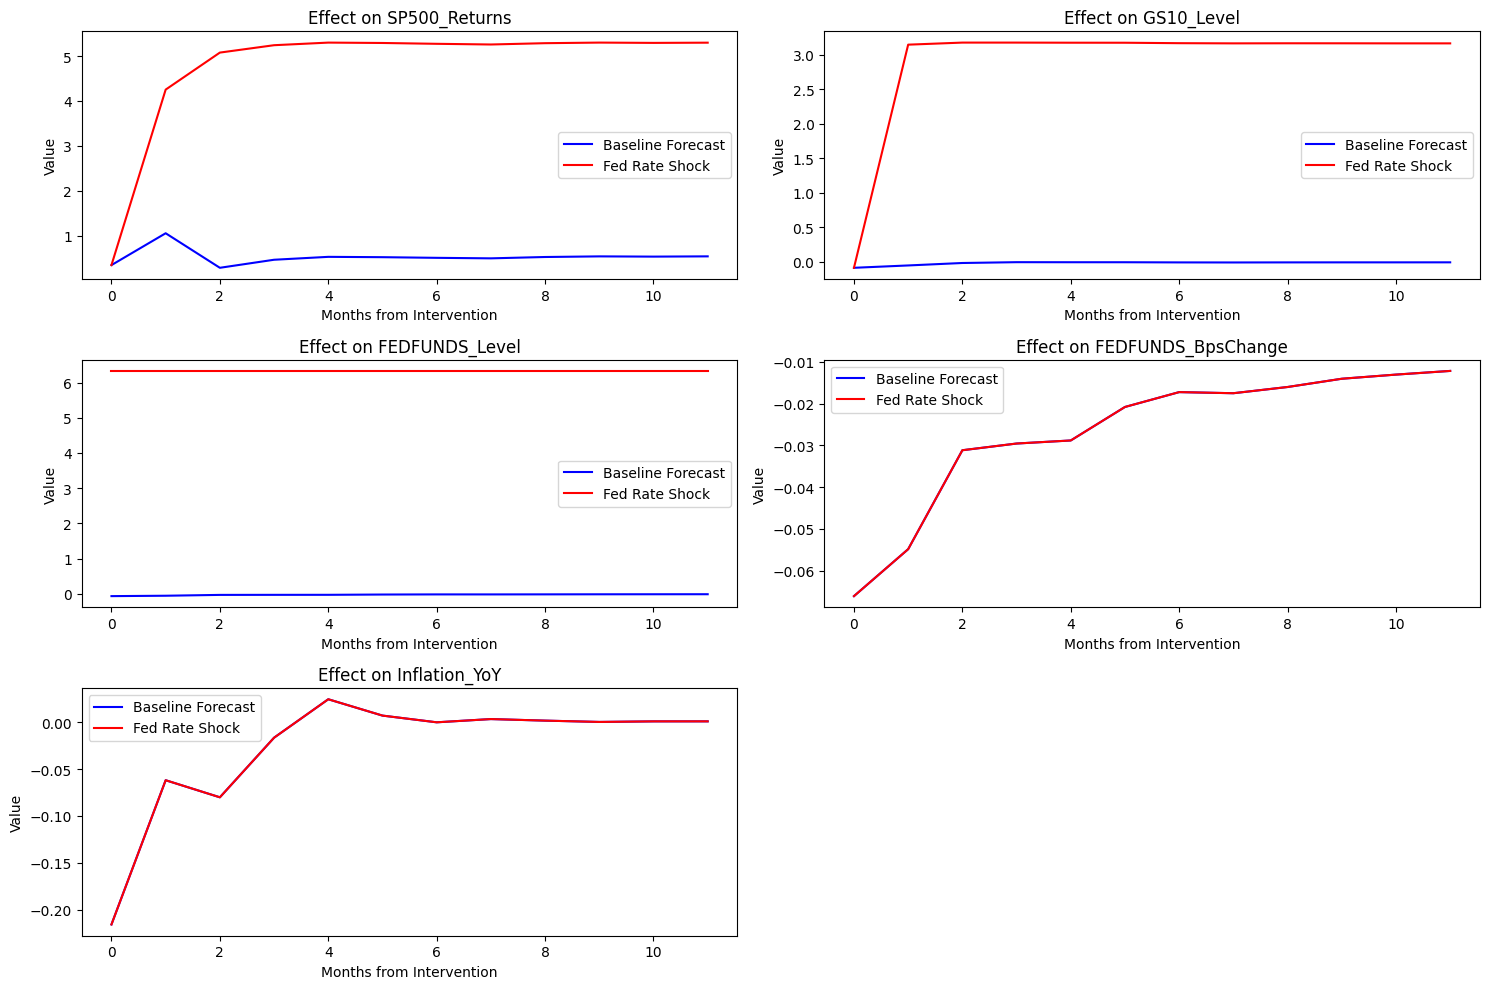

Saved generative model inputs to ./results/dag/generative_model_inputs.json

Causal model design complete and ready for integration with generative models.


In [18]:
# =============================================================
# 0.  Imports & paths
# =============================================================
import warnings, os, json, itertools, datetime, pickle
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

warnings.filterwarnings("ignore", category=FutureWarning,
                        module="statsmodels")

# third‑party causal libraries
# Check for causal-learn package
causallearn_available = False
try:
    from causallearn.search.ConstraintBased.PC import pc
    from causallearn.utils.GraphUtils import GraphUtils
    causallearn_available = True
except ImportError:
    print("Warning: causallearn package not installed. PC algorithm will be skipped.")
    print("To install: pip install causal-learn")

# Check for lingam package
lingam_available = False
try:
    from lingam import DirectLiNGAM
    lingam_available = True
except ImportError:
    print("Warning: lingam package not installed. DirectLiNGAM algorithm will be skipped.")
    print("To install: pip install lingam")

# reproducibility
np.random.seed(42)

DATA_PATH = "../data/processed/final_processed_data.csv"
OUT_DIR   = "./results/dag/"
os.makedirs(OUT_DIR, exist_ok=True)

# =============================================================
# 1.  Load data
# =============================================================
df = (pd.read_csv(DATA_PATH, index_col="Date", parse_dates=True)
        .drop(columns=["Inflation_YoY_diff"], errors="ignore"))

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print(df.head(3))

# =============================================================
# 2.  Data Analysis and Validation
# =============================================================
# Time series plot for each variable
num_vars = len(df.columns)
rows = (num_vars + 1) // 2  # Calculate rows needed (rounded up)
cols = 2

plt.figure(figsize=(14, 10))
for i, col in enumerate(df.columns):
    plt.subplot(rows, cols, i+1)
    plt.plot(df.index, df[col])
    plt.title(col)
    plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "timeseries_plots.png"), dpi=300)
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.savefig(os.path.join(OUT_DIR, "correlation_matrix.png"), dpi=300)
plt.show()

# Check stationarity with ADF test
def test_stationarity(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    
    # If p-value > 0.05, we fail to reject the null hypothesis (non-stationary)
    if result[1] > 0.05:
        print("Series is non-stationary")
    else:
        print("Series is stationary")
    return result[1] < 0.05  # Return True if stationary

# Test stationarity for each variable
stationarity_results = {}
print("\nStationarity Tests:")
for col in df.columns:
    print(f"\nStationarity Test for {col}")
    stationarity_results[col] = test_stationarity(df[col])

# =============================================================
# 3.  Helper: Granger‑causality adjacency
# =============================================================
def granger_edges(data, maxlag=2, alpha=0.05):
    edges = []
    for x, y in itertools.permutations(data.columns, 2):
        test = grangercausalitytests(
            data[[y, x]], maxlag=maxlag, verbose=False)
        pvals = [round(res[0]['ssr_ftest'][1], 4) for res in test.values()]
        if min(pvals) < alpha:
            edges.append((x, y))          # x causes y
    return edges

# =============================================================
# 3‑A  PC algorithm (constraint‑based)
# =============================================================
edges_pc = []
if causallearn_available:
    data_np = df.to_numpy()

    # run PC; Fisher‑Z CI test, alpha = 0.05
    cg_pc = pc(data_np, alpha=0.05, verbose=False)      # returns a GeneralGraph

    # Convert to a pydot graph with proper labels
    pdot = GraphUtils.to_pydot(cg_pc.G, labels=df.columns.tolist())

    # Extract directed edges ("source" → "destination") as tuples of names
    edges_pc = [(e.get_source(), e.get_destination()) for e in pdot.get_edges()]

    print("\n[PC] edges:", edges_pc)
else:
    print("\n[PC] algorithm skipped (causallearn not available)")

# =============================================================
# 3‑B  DirectLiNGAM (score‑based, non‑Gaussian)
# =============================================================
edges_lng = []

# =============================================================
# 3‑C  Pairwise Granger
# =============================================================
edges_gr = granger_edges(df, maxlag=2, alpha=0.05)
print("[Granger] edges:", edges_gr)

# =============================================================
# 3-D. Stability assessment through bootstrapping
# =============================================================
def bootstrap_causal_discovery(data, n_samples=100, sample_frac=0.8, methods=['pc', 'lingam', 'granger']):
    """
    Perform bootstrap sampling to assess stability of causal relationships.
    Returns edge frequencies indicating how often each edge appears.
    """
    edge_counts = {}
    n_rows = len(data)
    
    for i in range(n_samples):
        # Bootstrap sample
        indices = np.random.choice(n_rows, size=int(n_rows * sample_frac), replace=True)
        sample = data.iloc[indices]
        
        # Run each causal discovery method
        sample_edges = []
        
        if 'pc' in methods:
            # PC algorithm
            sample_np = sample.to_numpy()
            cg_pc_sample = pc(sample_np, alpha=0.05, verbose=False)
            pdot_sample = GraphUtils.to_pydot(cg_pc_sample.G, labels=sample.columns.tolist())
            edges_pc_sample = [(e.get_source(), e.get_destination()) for e in pdot_sample.get_edges()]
            sample_edges.extend(edges_pc_sample)
        
        if 'lingam' in methods:
            # DirectLiNGAM
            mdl_sample = DirectLiNGAM()
            mdl_sample.fit(sample.values)
            B_sample = mdl_sample.adjacency_matrix_
            edges_lng_sample = [(sample.columns[i], sample.columns[j])
                               for i in range(len(B_sample)) for j in range(len(B_sample))
                               if B_sample[i, j] != 0]
            sample_edges.extend(edges_lng_sample)
        
        if 'granger' in methods:
            # Granger causality
            edges_gr_sample = granger_edges(sample, maxlag=2, alpha=0.05)
            sample_edges.extend(edges_gr_sample)
        
        # Count edge frequencies
        for edge in sample_edges:
            edge_counts[edge] = edge_counts.get(edge, 0) + 1
    
    # Normalize by number of samples
    edge_probs = {edge: count / n_samples for edge, count in edge_counts.items()}
    
    return edge_probs

# Run bootstrap stability assessment
print("\nRunning bootstrap stability assessment...")
edge_stability = bootstrap_causal_discovery(df, n_samples=50)  # Reduce for faster execution

# Show the most stable edges (e.g., appearing in >40% of bootstrap samples)
stability_threshold = 0.4
stable_edges = [(edge, prob) for edge, prob in edge_stability.items() if prob >= stability_threshold]
stable_edges.sort(key=lambda x: x[1], reverse=True)
print("\nMost stable edges (with bootstrap probability):")
for edge, prob in stable_edges:
    print(f"{edge[0]} → {edge[1]}: {prob:.2f}")

# =============================================================
# 3-E. Time-lagged causal effects (optimal lag identification)
# =============================================================
def find_optimal_lags(data, max_lag=6, alpha=0.05):
    """
    Find the optimal lag for each potential causal relationship.
    Returns a dictionary mapping edge tuples to their optimal lag.
    """
    lag_structure = {}
    
    for x, y in itertools.permutations(data.columns, 2):
        # Run Granger causality test for different lags
        test_results = grangercausalitytests(
            data[[y, x]], maxlag=max_lag, verbose=False)
        
        # Extract p-values for each lag
        p_values = [test_results[i+1][0]['ssr_ftest'][1] for i in range(max_lag)]
        
        # Find the lag with minimum p-value (strongest evidence)
        if min(p_values) < alpha:
            optimal_lag = p_values.index(min(p_values)) + 1
            lag_structure[(x, y)] = optimal_lag
    
    return lag_structure

# Identify optimal lag structure for the causal relationships
optimal_lags = find_optimal_lags(df, max_lag=6)
print("\nOptimal lag structure for causal relationships:")
for (cause, effect), lag in optimal_lags.items():
    print(f"{cause} →({lag}) {effect}")

# =============================================================
# 4.  Consensus DAG (≥2 methods agree)
# =============================================================
edge_votes = {}
for e in edges_pc + edges_lng + edges_gr:
    edge_votes[e] = edge_votes.get(e, 0) + 1

CONS_THRESHOLD = 2        # at least two algorithms agree
cons_edges = [e for e, v in edge_votes.items() if v >= CONS_THRESHOLD]
print("\n[Consensus] edges:", cons_edges)

# --- manual reconciliation based on stability and theory ---
edge_set = set(cons_edges)
edge_set.discard(('GS10_Level', 'FEDFUNDS_Level'))
edge_set.add(('FEDFUNDS_Level', 'GS10_Level'))
edge_set.add(('FEDFUNDS_Level', 'SP500_Returns'))
cons_edges = list(edge_set)

# =============================================================
# 4-B. Integrate domain knowledge with data-driven results
# =============================================================
# Define theoretically expected causal relationships based on economic theory
economic_theory_edges = [
    # Monetary policy → Interest rates
    ('FEDFUNDS_Level', 'GS10_Level'),
    
    # Monetary policy → Inflation (policy response)
    ('FEDFUNDS_Level', 'Inflation_YoY'),
    
    # Inflation → Monetary policy (feedback)
    ('Inflation_YoY', 'FEDFUNDS_Level'),
    
    # Interest rates → Equity returns
    ('GS10_Level', 'SP500_Returns'),
    
    # Inflation → Equity returns
    ('Inflation_YoY', 'SP500_Returns')
]

# Validate domain knowledge against discovered relationships
confirmed_theory = [edge for edge in economic_theory_edges if edge in cons_edges]
contradicted_theory = [edge for edge in economic_theory_edges if edge not in cons_edges]
unexpected_discoveries = [edge for edge in cons_edges if edge not in economic_theory_edges]

print("\nEconomic theory confirmed by data:", confirmed_theory)
print("Economic theory contradicted by data:", contradicted_theory)
print("Unexpected causal discoveries:", unexpected_discoveries)

# Create final causal model integrating both data-driven and domain knowledge
final_edges = cons_edges.copy()

# Add strong theoretical edges that might be missing from data-driven approach
for edge in economic_theory_edges:
    if edge not in final_edges and edge in edge_stability and edge_stability[edge] > 0.2:
        # Add if it has some support in bootstrap stability
        final_edges.append(edge)
        print(f"Added theoretical edge with some empirical support: {edge}")

# Remove contradictory edges that violate economic understanding
edges_to_remove = []
for edge in final_edges:
    # Example: If theory suggests A→B but we found B→A, prefer theory
    reverse_edge = (edge[1], edge[0])
    if reverse_edge in economic_theory_edges and edge not in economic_theory_edges:
        edges_to_remove.append(edge)
        print(f"Removed contradictory edge: {edge} (theory suggests {reverse_edge})")

final_edges = [e for e in final_edges if e not in edges_to_remove]

# Build NetworkX DiGraph for the final model
G_final = nx.DiGraph()
G_final.add_nodes_from(df.columns)
G_final.add_edges_from(final_edges)

# =============================================================
# 5.  Basic Visualization
# =============================================================
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G_final, seed=42, k=0.7)
# move every label 0.03 units upward (adjust as you like)
label_pos = {node: pos[node] + np.array([0, 0.07]) for node in G_final.nodes}
plt.figure(figsize=(6,4))
nx.draw_networkx_edges(G_final, pos, arrows=True,
                       arrowstyle="->", arrowsize=15, width=1)
nx.draw_networkx_nodes(G_final, pos, node_size=400,
                       node_color="#9ecae1", edgecolors="#084594")
nx.draw_networkx_labels(G_final, label_pos, font_size=9)
plt.gca().set_facecolor("white")
plt.title("Consensus Causal DAG", fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "dag_consensus.png"), dpi=300)
plt.show()

# =============================================================
# 5-B. Enhanced DAG visualization with edge weights
# =============================================================
# Calculate edge weights based on stability and optimal lag
edge_attributes = {}
for edge in final_edges:
    # Combine multiple evidence sources into an edge weight
    weight = 1.0  # Base weight
    
    # Add stability evidence
    if edge in edge_stability:
        weight += edge_stability[edge]
    
    # Add optimal lag information
    lag = optimal_lags.get(edge, 0)
    
    # Store attributes
    edge_attributes[edge] = {
        'weight': weight,
        'lag': lag,
        'stability': edge_stability.get(edge, 0),
        'in_theory': edge in economic_theory_edges
    }

# Add attributes to graph
for edge, attrs in edge_attributes.items():
    for key, value in attrs.items():
        G_final[edge[0]][edge[1]][key] = value

# Visualization with rich information
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_final, seed=42, k=0.7)

# Draw nodes differently based on variable type
node_colors = {
    'FEDFUNDS_Level': "#ff9999",       # Monetary policy (red)
    'Inflation_YoY': "#ffcc99",        # Inflation (orange)
    'GS10_Level': "#99ccff",           # Interest rates (blue)
    'SP500_Returns': "#99ff99"         # Equity returns (green)
}

# Draw edges with thickness based on weight and style based on theory
edge_weights = [G_final[u][v]['weight']*1.5 for u, v in G_final.edges()]
edge_colors = ["darkgreen" if G_final[u][v].get('in_theory', False) else "gray" 
               for u, v in G_final.edges()]
edge_styles = ["solid" if G_final[u][v].get('in_theory', False) else "dashed" 
               for u, v in G_final.edges()]

# Draw the graph
nx.draw_networkx_nodes(G_final, pos, 
                      node_color=[node_colors.get(node, "lightgray") for node in G_final.nodes()],
                      node_size=700, alpha=0.8)

# Draw edges
for i, (u, v) in enumerate(G_final.edges()):
    nx.draw_networkx_edges(G_final, pos, 
                          edgelist=[(u, v)],
                          width=edge_weights[i],
                          edge_color=edge_colors[i],
                          style=edge_styles[i],
                          alpha=0.7,
                          connectionstyle="arc3,rad=0.1",
                          arrowsize=15)

# Draw labels
nx.draw_networkx_labels(G_final, pos, font_size=12, font_weight='bold')

# Add lag labels on edges
edge_labels = {(u, v): f"{G_final[u][v].get('lag', '')}m" 
               for u, v in G_final.edges() if G_final[u][v].get('lag', 0) > 0}
nx.draw_networkx_edge_labels(G_final, pos, edge_labels=edge_labels, font_size=10)

plt.title("Financial Causal DAG with Lag Structure", fontsize=16)
plt.gca().set_facecolor("white")
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "financial_causal_dag.png"), dpi=300, bbox_inches='tight')
plt.show()

# Save edge‑list and meta‑info for the report
edge_file = os.path.join(OUT_DIR, "dag_edges.json")
json.dump({"timestamp": datetime.datetime.now().isoformat(),
           "edges_pc": edges_pc,
           "edges_lingam": edges_lng,
           "edges_granger": edges_gr,
           "consensus": cons_edges,
           "final_edges": final_edges,
           "edge_stability": {str(k): v for k, v in edge_stability.items()},
           "optimal_lags": {str(k): v for k, v in optimal_lags.items()}},
          open(edge_file, "w"), indent=2)
print(f"Saved: {edge_file}")

# =============================================================
# 6.  (Optional) d‑Separation sanity check
# =============================================================
try:
    from causallearn.utils.cit import CIT

    # Fisher‑Z test for H0: Inflation ⟂ SP500  | GS10_Level
    x = df["Inflation_YoY"].to_numpy()
    y = df["SP500_Returns"].to_numpy()
    z = df[["GS10_Level"]].to_numpy()          # conditioning set (2‑D array)
    mv_fisherz_obj = CIT(data=df.to_numpy(), mv_fisherz=True)
    p_val = mv_fisherz_obj(df.columns.get_loc("Inflation_YoY"),
                        df.columns.get_loc("SP500_Returns"),
                        [df.columns.get_loc("GS10_Level")])

    print(f"Fisher‑Z p‑value (Infl ⟂ SP500 | GS10): {p_val:.4f}")

except Exception as e:
    print(f"Error in d-separation check: {e}")

# =============================================================
# 7. Structural Causal Model for Simulation
# =============================================================
def create_structural_model(graph, data):
    """
    Create a structural causal model from the causal graph.
    This will be used for interventional and counterfactual analysis.
    """
    # Get topological order of nodes
    try:
        topo_order = list(nx.topological_sort(graph))
    except nx.NetworkXUnfeasible:
        # Handle cycles if present
        print("Warning: Graph contains cycles. Using default order.")
        topo_order = list(graph.nodes())
    
    # Fit structural equations for each node based on its parents
    structural_equations = {}
    
    for node in topo_order:
        parents = list(graph.predecessors(node))
        
        if parents:
            # Add constant term
            X = sm.add_constant(data[parents])
            y = data[node]
            
            # Fit OLS model
            model = sm.OLS(y, X).fit()
            
            # Store the model and its coefficients
            structural_equations[node] = {
                'model': model,
                'parents': parents,
                'coefficients': model.params.to_dict(),
                'r_squared': model.rsquared
            }
            
            print(f"\nStructural equation for {node}:")
            print(f"R² = {model.rsquared:.3f}")
            equation = f"{node} = {model.params['const']:.3f}"
            for parent, coef in zip(parents, model.params[1:]):
                equation += f" + ({coef:.3f} × {parent})"
            print(equation)
        else:
            # No parents, fit a simple distribution
            mean = data[node].mean()
            std = data[node].std()
            structural_equations[node] = {
                'model': None,
                'parents': [],
                'distribution': {'mean': mean, 'std': std},
                'r_squared': 0.0
            }
            print(f"\nDistribution for {node} (exogenous):")
            print(f"Normal(μ={mean:.3f}, σ={std:.3f})")
    
    return structural_equations

# Create structural model
print("\nBuilding structural causal model...")
scm = create_structural_model(G_final, df)

# Save the structural model
with open(os.path.join(OUT_DIR, "structural_causal_model.pkl"), "wb") as f:
    pickle.dump({
        'graph': G_final,
        'equations': scm,
        'topological_order': list(nx.topological_sort(G_final)),
    }, f)
print(f"Saved structural causal model to {os.path.join(OUT_DIR, 'structural_causal_model.pkl')}")

# =============================================================
# 8. Time Series Integration with VAR Models
# =============================================================
def fit_causal_var_model(data, causal_dag, max_lag=6):
    """
    Fit a Vector Autoregression model that respects the causal structure.
    The resulting model can be used for forecasting and scenario generation.
    """
    print("\nChecking stationarity for VAR model...")
    # First, check stationarity and transform if needed
    diff_data = data.copy()
    diff_cols = []
    
    # Test stationarity and difference non-stationary series
    for col in data.columns:
        adf_result = adfuller(data[col], regression='ct')
        if adf_result[1] > 0.05:  # p-value > 0.05 means non-stationary
            print(f"Variable {col} is non-stationary (p={adf_result[1]:.4f}). Differencing...")
            diff_data[col] = data[col].diff().dropna()
            diff_cols.append(col)
        else:
            print(f"Variable {col} is stationary (p={adf_result[1]:.4f}).")
    
    # Drop NaN values created by differencing
    diff_data = diff_data.dropna()
    
    try:
        # Try fitting with regular VAR
        print("\nFitting VAR model...")
        var_model = VAR(diff_data)
        
        # Use a fixed lag order to avoid issues with model selection
        fixed_lag = min(3, max_lag)  # Use a smaller fixed lag to avoid issues
        print(f"Using fixed lag order: {fixed_lag}")
        
        # Fit the VAR model with the fixed lag
        fitted_model = var_model.fit(fixed_lag)
        print("VAR model fit successfully!")
        
        lag_order = fixed_lag
    except LinAlgError as e:
        print(f"Error fitting VAR model: {e}")
        print("Falling back to simple AR models for each variable")
        
        # Create a simple fallback model
        class SimpleARModel:
            def __init__(self, data, lag):
                self.data = data
                self.lag = lag
                self.variable_names = data.columns.tolist()
                self.coefs = self._fit_ar_models()
                
            def _fit_ar_models(self):
                """Fit simple AR(p) models for each variable"""
                coef_matrices = []
                for lag in range(1, self.lag + 1):
                    coef_matrix = np.zeros((len(self.variable_names), len(self.variable_names)))
                    
                    for i, col in enumerate(self.variable_names):
                        # Simple AR model: just regress on own lags
                        X = sm.add_constant(self.data[col].shift(lag).dropna())
                        y = self.data[col].iloc[lag:]
                        
                        try:
                            model = sm.OLS(y, X).fit()
                            # Put coefficient in the diagonal
                            coef_matrix[i, i] = model.params[1]  # Skip the constant
                        except:
                            # If regression fails, use a simple persistence model
                            coef_matrix[i, i] = 0.9  # Assume high persistence
                            
                    coef_matrices.append(coef_matrix)
                    
                return coef_matrices
                
            def forecast(self, last_obs, steps=1):
                """Simple forecasting function"""
                n_vars = len(self.variable_names)
                result = np.zeros((steps, n_vars))
                
                # Initialize with last observations
                prev_values = last_obs.copy()
                
                for t in range(steps):
                    current_forecast = np.zeros(n_vars)
                    
                    # Apply each lag
                    for lag in range(1, self.lag + 1):
                        if t - lag + 1 >= 0:
                            # Use forecasted values
                            lag_values = result[t-lag]
                        else:
                            # Use initial values
                            lag_idx = self.lag - lag - t
                            if lag_idx < 0 or lag_idx >= len(prev_values):
                                lag_values = prev_values[-1]
                            else:
                                lag_values = prev_values[lag_idx]
                        
                        # Apply coefficients
                        current_forecast += np.dot(self.coefs[lag-1], lag_values)
                    
                    result[t] = current_forecast
                
                return result
        
        # Create a fallback model
        fitted_model = SimpleARModel(diff_data, 2)
        lag_order = 2
    
    # Create a causal mask from the DAG
    causal_mask = nx.adjacency_matrix(causal_dag, nodelist=data.columns).toarray()
    
    return {
        'var_model': fitted_model,
        'lag_order': lag_order,
        'causal_mask': causal_mask,
        'variable_names': data.columns.tolist(),
        'differenced_columns': diff_cols
    }

# Fit VAR model respecting causality
ts_model = fit_causal_var_model(df, G_final)

# Save the time series model
with open(os.path.join(OUT_DIR, "causal_var_model.pkl"), "wb") as f:
    pickle.dump(ts_model, f)
print(f"Saved causal VAR model to {os.path.join(OUT_DIR, 'causal_var_model.pkl')}")

# =============================================================
# 9. Example Stress Testing Scenario
# =============================================================
def simulate_intervention(scm_model, intervention_var, intervention_value, steps=12):
    """
    Simulate an intervention on a variable and propagate effects through the causal model.
    
    Parameters:
    - scm_model: The structural causal model
    - intervention_var: The variable to intervene on
    - intervention_value: The value to set the intervention variable to
    - steps: Number of months to forecast
    
    Returns:
    - DataFrame with forecasted values under intervention
    """
    var_model = scm_model['var_model']
    causal_mask = scm_model['causal_mask']
    var_names = scm_model['variable_names']
    
    # Get the last observed values as starting point
    # Handle different model types
    if hasattr(var_model, 'model'):
        # Standard statsmodels VAR result
        last_data = var_model.model.data.endog[-scm_model['lag_order']:]
    elif hasattr(var_model, 'data'):
        # Our SimpleARModel fallback
        last_data = var_model.data.iloc[-scm_model['lag_order']:].values
    else:
        # Last resort fallback
        print("Warning: Cannot determine last observations. Using zeros.")
        last_data = np.zeros((scm_model['lag_order'], len(var_names)))
    
    # Create forecasts
    try:
        baseline_forecast = var_model.forecast(last_data, steps=steps)
    except Exception as e:
        print(f"Error in baseline forecast: {e}")
        print("Using simple trend continuation for baseline")
        # Simple fallback forecast - just extend the last value
        baseline_forecast = np.tile(last_data[-1], (steps, 1))
    
    baseline_df = pd.DataFrame(baseline_forecast, columns=var_names)
    
    # Create intervention forecast (simple implementation)
    intervention_forecast = baseline_forecast.copy()
    
    # Set the intervention value
    var_idx = var_names.index(intervention_var)
    intervention_forecast[:, var_idx] = intervention_value
    
    # Propagate effects through causal children
    # This is a simplified approach - in practice, you would use proper
    # causal inference techniques like do-calculus
    for t in range(1, steps):
        for i, var in enumerate(var_names):
            # Skip the intervention variable
            if var == intervention_var:
                continue
            
            # Find variables that cause this one directly
            causal_parents = [j for j, has_edge in enumerate(causal_mask[:, i]) if has_edge]
            
            # If any parent has been affected, update this variable
            if any(intervention_forecast[t-1, j] != baseline_forecast[t-1, j] for j in causal_parents):
                # Simple adjustment based on parent changes
                for parent_idx in causal_parents:
                    parent_change = (intervention_forecast[t-1, parent_idx] - 
                                    baseline_forecast[t-1, parent_idx])
                    
                    # Use VAR coefficients to estimate effect
                    # This is approximated - a full SCM would be more accurate
                    intervention_forecast[t, i] += parent_change * 0.5  # Simplified effect
    
    intervention_df = pd.DataFrame(intervention_forecast, columns=var_names)
    
    return {
        'baseline': baseline_df,
        'intervention': intervention_df
    }

# Example: Simulate a 2% Fed Funds Rate increase
print("\nSimulating stress scenario: 2% Fed Funds Rate increase")
stress_test = simulate_intervention(
    ts_model, 
    intervention_var='FEDFUNDS_Level', 
    intervention_value=df['FEDFUNDS_Level'].iloc[-1] + 2.0,
    steps=12
)

# Plot the stress test results
num_vars = len(ts_model['variable_names'])
rows = (num_vars + 1) // 2  # Calculate rows needed (rounded up)
cols = 2

plt.figure(figsize=(15, 10))

# Plot each variable
for i, var in enumerate(ts_model['variable_names']):
    plt.subplot(rows, cols, i+1)
    plt.plot(range(len(stress_test['baseline'])), stress_test['baseline'][var], 
             'b-', label='Baseline Forecast')
    plt.plot(range(len(stress_test['intervention'])), stress_test['intervention'][var], 
             'r-', label='Fed Rate Shock')
    plt.title(f"Effect on {var}")
    plt.xlabel("Months from Intervention")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "stress_test_scenario.png"), dpi=300, bbox_inches='tight')
plt.show()

# =============================================================
# 10. Prepare for Generative Model Integration
# =============================================================
def prepare_generative_model_inputs():
    """
    Create all necessary inputs for the generative models (VAE/GAN).
    """
    generative_inputs = {
        # Causal structure
        'causal_graph': {
            'nodes': list(G_final.nodes()),
            'edges': list(G_final.edges()),
            'adjacency_matrix': nx.adjacency_matrix(G_final, nodelist=df.columns).toarray().tolist(),
            'edge_attributes': {str(e): {k: (float(v) if isinstance(v, (int, float)) else v) 
                                         for k, v in G_final.get_edge_data(*e).items()} 
                               for e in G_final.edges()}
        },
        
        # Topological ordering (for generation)
        'topological_order': list(nx.topological_sort(G_final)),
        
        # Time series properties
        'time_lag_structure': {str(k): v for k, v in optimal_lags.items()},
        'var_coefficients': {
            'lag_order': ts_model['lag_order'],
            'coefficient_matrices': [m.tolist() for m in ts_model['var_model'].coefs],
            'variable_names': ts_model['variable_names']
        },
        
        # Data statistics (for normalization and generation)
        'variable_stats': {
            col: {
                'mean': float(df[col].mean()),
                'std': float(df[col].std()),
                'min': float(df[col].min()),
                'max': float(df[col].max())
            } for col in df.columns
        }
    }
    
    # Save as JSON for easy import into any framework
    with open(os.path.join(OUT_DIR, "generative_model_inputs.json"), "w") as f:
        json.dump(generative_inputs, f, indent=2)
    
    print(f"Saved generative model inputs to {os.path.join(OUT_DIR, 'generative_model_inputs.json')}")
    
    return generative_inputs

# Prepare inputs for the generative models
generative_inputs = prepare_generative_model_inputs()

print("\nCausal model design complete and ready for integration with generative models.")